# Pré-treinamento de LMs: Encoder–Decoder, Atenção e Fundamentos de Transformers


**Objetivos de aprendizagem**
- Compreender a arquitetura **encoder–decoder** clássica e seus papéis.
- Entender o mecanismo de **atenção**, com ênfase em **self-attention** e **masked attention**.
- Reconhecer os blocos de construção de **Transformers** (multi-head attention, feed-forward, layer norm, positional encodings).
- Relacionar **objetivos de pré-treino** (MLM, CLM, denoising) às **arquiteturas** (BERT, GPT, T5).
- Preparar terreno conceitual para estudar **Transformers completos** e pré-treinamento em larga escala.

In [ ]:
# Instalação das dependências localmente
# Se estiver rodando localmente, descomente a linha abaixo para instalar as dependências
# ! pip install -r requirements.txt

In [ ]:
# Se rodando no Google Colab, descomente a linha abaixo para montar o Google Drive
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

In [ ]:
# Instalação das dependências no Google Colab
# Mude CAMINHO_PARA_REPO para o caminho correto do seu repositório no seu Google Drive
# ! pip install -r /content/drive/MyDrive/UFMS/Aulas/2025-2/TOPIA/repo/TopicosIA-2025-02/requirements.txt

## 0) Do RNN ao Transformer

Até aqui estudamos **RNN** e **LSTM**, que foram os principais blocos para lidar com sequências.

- **RNN**: processa token por token, passando um estado oculto adiante.
- **LSTM**: adiciona mecanismos de porta para lidar melhor com dependências longas.

**Problemas principais:**
1. **Dependências longas**: fica difícil para a rede "lembrar" informações distantes.
2. **Paralelismo limitado**: precisa processar passo a passo → treinos lentos.
3. **Gargalo de contexto**: no encoder–decoder clássico, toda a entrada vira um único vetor fixo.

Surge a **atenção**: em vez de depender de um vetor único ou de percorrer a sequência inteira, podemos “olhar” diretamente para diferentes partes da entrada.

## 1) Encoder–Decoder (visão geral)

<br/>
<img src="https://raw.githubusercontent.com/bmnogueira-ufms/TopicosIA-2025-02/main/images/encoder_decoder_1.png" width="50%">

<br/>
<img src="https://raw.githubusercontent.com/bmnogueira-ufms/TopicosIA-2025-02/main/images/encoder_decoder_2.png" width="50%">



### Ideia central
Em tarefas seq2seq (como tradução ou sumarização):

- O **encoder** lê a sequência de entrada e produz **representações**.  
- O **decoder** gera a saída passo a passo, consultando essas representações.

Três cenários clássicos:

1. **Sem atenção (RNN/LSTM clássico)**  
   O decoder começa apenas com o **estado final** do encoder.  
   Limitação: um único vetor precisa resumir toda a entrada → dependências longas ficam difíceis.  

2. **Com atenção (Bahdanau/Luong)**  
   A cada passo do decoder, ele “olha” para **todos** os estados do encoder e decide em quais focar.  
   Resolve o gargalo do vetor único.  

3. **Transformer**  
   Substitui a recorrência por **atenção paralela** (self-attention + encoder–decoder attention).  
   Muito mais rápido e escalável.


### Como o decoder funciona **sem atenção**?

No seq2seq original (Sutskever et al., 2014), o **encoder** lê a entrada e **só entrega o último estado oculto** para o decoder.

#### Passo 1 – Encoder
Entrada:
```
x = (“I”, “like”, “cats”)
```
Encoder RNN/LSTM lê token por token e termina com um **estado final**:
```
h_final = resumo de toda a sequência
```

---

#### Passo 2 – Decoder
- O decoder recebe esse `h_final` como **condição inicial**.  
- Ele não tem acesso a todos os vetores `h1, h2, ..., hn`.  
- A cada passo, ele só depende:
  - Do estado anterior do decoder (`h_{t-1}`)  
  - Do token anterior gerado (`y_{t-1}`)  

Processo:
1. Estado inicial = `h_final` do encoder.  
2. Gera `y1`.  
3. Usa `y1` + estado atualizado para gerar `y2`.  
4. Continua até `<eos>`.

---

#### Exemplo intuitivo
Tradução sem atenção:

Entrada: `"I like cats"`  
Encoder → gera **um vetor único** (como se fosse um "resumo").  
Decoder → começa desse resumo e tenta produzir: `"Eu gosto de gatos"`.

Problema:  
- Se a frase for longa, esse vetor único não consegue carregar todos os detalhes.  
- Informação do início da frase pode se perder.  

---

#### Limitações
- **Gargalo da informação**: um vetor só precisa guardar toda a sentença.  
- **Dependências longas**: quanto maior a entrada, pior a memória.  
- **Qualidade de tradução**: boa em frases curtas, mas degrada em frases longas.

---

#### Resumindo
- **Sem atenção**: Decoder só enxerga o **estado final do encoder**.  
- **Com atenção**: Decoder tem acesso a **todos os estados do encoder** (`H_enc`) e escolhe a cada passo onde focar.

### E como o decoder funciona  **com atenção**?

#### Papéis de cada componente
- **Encoder**: recebe `x = (x1, ..., xn)` e produz `H_enc = (h1, ..., hn)` (representações por token).  
- **Decoder**: gera `y = (y1, ..., ym)` condicionado em `H_enc` e no histórico já gerado (**autoregressivo**).

##### O que significa "autoregressivo"?

Um modelo **autoregressivo** é aquele que **prevê o próximo elemento de uma sequência usando apenas os elementos anteriores**.  

Ou seja: a geração é feita **passo a passo**, sempre se apoiando no histórico já produzido.

##### Exemplo simples (texto)
Se já escrevi:  
> "O gato está"  

Um modelo autoregressivo tenta prever qual é a **próxima palavra**.  
- Pode ser "dormindo", "brincando", "pulando"...  
Ele escolhe a mais provável segundo o treinamento.

Depois, esse novo token passa a **entrar no histórico**.  
Na próxima rodada, o modelo vai prever o token seguinte condicionando em:  
> "O gato está dormindo"

E assim por diante.

##### Características importantes
- **Passo a passo (token por token):** não gera tudo de uma vez.  
- **Depende do histórico:** cada nova previsão considera o que já foi gerado.  
- **Exige máscara causal no decoder:** para garantir que o modelo só veja o **passado** e não "espie" o futuro.

### Fluxo simplificado
1. `embed(x)` → transforma tokens em vetores (e adiciona posições se necessário).  
2. `encoder(x)` → gera `H_enc`.  
3. `decoder(y_<t, H_enc)` → gera o próximo token `y_t`.  
   - Com **máscara causal** no decoder (não olha o futuro).  
   - Com **atenção encoder–decoder** (foca nas partes relevantes de `H_enc`).

### Exemplo didático: Encoder e Decoder em ação

Vamos imaginar uma tarefa de **tradução**: traduzir do inglês para o português.

---

#### Entrada
Frase em inglês:  

`x = (“I”, “like”, “cats”)`

#### Passo 1 – Encoder
O **encoder** recebe cada token de entrada e produz uma **representação vetorial** (embedding contextualizado):  

`h1 = f(“I”)`
`h2 = f(“like”)`
`h3 = f(“cats”)`

Resultado:  

`H_enc = (h1, h2, h3)`

Cada vetor `h_i` não é só uma tradução da palavra, mas já leva em conta o **contexto**.  
Exemplo: `h2` representa "like" no contexto de "I like cats" (não “like” de “similar to”).

- Forma de `H_enc`
  - Se a frase tem `n` tokens e cada vetor tem dimensão `d` (ex.: d = 128), então `H_enc` é uma **matriz** de forma `(n, d)`.  
  - Exemplo: Frase com 3 tokens (`n=3`)
    - Representações de dimensão 123 (`d=128`)

`H_enc = [`

`h1 (dim=128)`

`h2 (dim=128)`

`h3 (dim=128)`

`]`

---

#### Passo 2 – Decoder
O **decoder** vai gerar a tradução em português, **um token de cada vez** (**autoregressivo**).  
Ele usa duas informações:
1. Os vetores do encoder `H_enc`.  
2. Os tokens que **já foram gerados** na saída.

Processo:

1. Começa com um token especial `<sos>` (“start of sequence”).  
2. Gera o primeiro token:  

`y1 = “Eu”`

3. Para o próximo passo, o decoder usa:  
- o histórico já gerado (`"Eu"`)  
- + as representações do encoder (`H_enc`)  
E gera:  

`y2 = “gosto”`

4. Repete o processo para gerar:  

`y3 = “de”`
`y4 = “gatos”`
`y5 =    # token de fim`

#### Como o `H_enc` é consumido pelo decoder?

O `H_enc` é o **estoque de informações** da frase de entrada:  um vetor por token, guardado em uma matriz `(n, d)`.

O **decoder** não pega tudo de uma vez.  Ele consulta `H_enc` a **cada passo de geração**. É aqui que entra a **atenção**.


##### Passo a passo

1. **Encoder processa a entrada**

`x = (“I”, “like”, “cats”)`
`H_enc = (h1, h2, h3)`

Cada `h_i` carrega o sentido contextual de cada palavra.

2. **Decoder começa a gerar a saída**
- No passo 1, recebe `<sos>` e gera `y1 = "Eu"`.  
- Para isso, ele olha para `H_enc` inteiro e calcula **pesos de atenção**:  
  ```
  atenção sobre (h1, h2, h3) -> foca mais em h1 ("I")
  ```

3. **Passo 2 do decoder**
- Histórico: `"Eu"`  
- Consulta novamente `H_enc` e gera:  
  ```
  atenção sobre (h1, h2, h3) -> foca mais em h2 ("like")
  y2 = "gosto"
  ```

4. **Passo 3 do decoder**
- Histórico: `"Eu gosto"`  
- Consulta `H_enc` e agora foca em `h3 ("cats")`:  
  ```
  y3 = "gatos"
  ```

##### Resumindo
- O `H_enc` **não é consumido/desgastado** (não vai diminuindo).  
- Ele é uma **memória fixa**, calculada pelo encoder.  
- O decoder a cada passo pergunta:  
> "De quais vetores de `H_enc` eu preciso agora para gerar o próximo token?"  

Essa "pergunta" é feita via **mecanismo de atenção**, que gera pesos diferentes a cada passo.

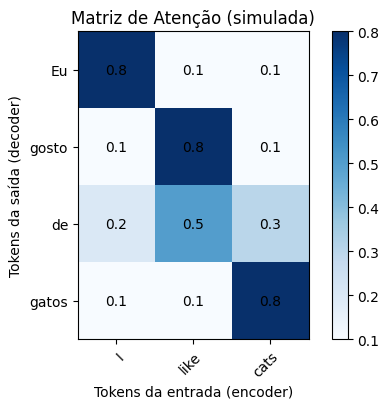

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Frase de entrada (encoder)
src_tokens = ["I", "like", "cats"]

# Frase de saída (decoder)
tgt_tokens = ["Eu", "gosto", "de", "gatos"]

# Matriz de atenção simulada (linhas = saída, colunas = entrada)
# Cada linha soma ~1
attention = np.array([
    [0.8, 0.1, 0.1],  # "Eu" foca em "I"
    [0.1, 0.8, 0.1],  # "gosto" foca em "like"
    [0.2, 0.5, 0.3],  # "de" é difuso
    [0.1, 0.1, 0.8],  # "gatos" foca em "cats"
])

fig, ax = plt.subplots(figsize=(6,4))
im = ax.imshow(attention, cmap="Blues")

# Configura eixos
ax.set_xticks(np.arange(len(src_tokens)))
ax.set_yticks(np.arange(len(tgt_tokens)))
ax.set_xticklabels(src_tokens)
ax.set_yticklabels(tgt_tokens)

# Rotaciona labels da entrada
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Adiciona valores nas células
for i in range(len(tgt_tokens)):
    for j in range(len(src_tokens)):
        ax.text(j, i, f"{attention[i,j]:.1f}", ha="center", va="center", color="black")

ax.set_xlabel("Tokens da entrada (encoder)")
ax.set_ylabel("Tokens da saída (decoder)")
ax.set_title("Matriz de Atenção (simulada)")

plt.colorbar(im, ax=ax)
plt.show()

### Treino vs. Inferência no Decoder

O **decoder** precisa de uma entrada a cada passo para gerar o próximo token.  
A diferença entre **treino** e **inferência** está em **quem fornece essa entrada**.

---

#### Treino (teacher forcing)
- A cada passo, o decoder recebe o **token correto da saída anterior** (vindo do dataset de treino).  
- Exemplo:
  - Alvo: `["Eu", "gosto", "de", "gatos"]`
  - Passo 1: recebe `<sos>`, gera "Eu"  
  - Passo 2: **não importa o que ele previu no passo 1**, ele recebe **"Eu" verdadeiro** como entrada para gerar o próximo.  
- Isso acelera o aprendizado, porque o modelo não acumula erros passo a passo.  
- Mas pode criar uma **diferença entre treino e teste** (o famoso *exposure bias*).

Durante o treino, avaliamos o desempenho do decoder comparando **as distribuições de saída**  
(com logits ou probabilidades) com os **tokens-alvo verdadeiros**.

#### Função de perda mais usada
- **Cross-Entropy Loss** (ou **Negative Log-Likelihood**)  
- Calculada **token a token**, ignorando `<pad>` (tokens de preenchimento).  
- Fórmula simplificada:

$$
  \mathcal{L} = - \frac{1}{N} \sum_{t=1}^{N} \log P(y_t \mid y_{<t}, H_{enc})
  $$  

onde:
- $y_t$ é o token verdadeiro no passo *t*.  
- $P(y_t \mid y_{<t}, H_{enc})$ é a probabilidade que o modelo atribuiu ao token correto.  
- $N$ = número total de tokens válidos (sem contar `<pad>`).

#### Intuição
- Se o modelo prevê a palavra correta com **alta probabilidade**, a perda é **baixa**.  
- Se prevê com **baixa probabilidade**, a perda é **alta**.  
- Treinamos o modelo ajustando os pesos para **minimizar essa perda média**.


#### Métricas adicionais (além da loss)
- **Perplexidade (PPL)**: exponencial da cross-entropy média.  
   $$\text{PPL} = e^{\mathcal{L}}$$
Mede “quantas opções o modelo mantém abertas” em média.  
- **Acurácia token a token**: proporção de tokens em que a predição top-1 bateu com o alvo.  
- Em tradução ou geração de texto: **BLEU, ROUGE, METEOR** (avaliam similaridade da frase inteira).

---

#### Inferência (teste/uso real)
- O modelo **não tem o alvo verdadeiro** disponível.  
- Ele precisa usar como entrada **o próprio token que acabou de gerar**.  
- Exemplo:
  - Gera "Eu" → alimenta "Eu" para prever o próximo.  
  - Gera "gostou" (errado) → alimenta "gostou" e, a partir daí, pode se perder cada vez mais.  

---

#### Estratégias de geração
1. **Greedy decoding**  
   - Sempre escolhe o token mais provável em cada passo.  
   - Simples e rápido.  
   - Pode levar a frases pouco variadas ou truncadas.  

2. **Beam search**  
   - Mantém várias hipóteses (ex.: as 3 ou 5 sequências mais prováveis) em paralelo.  
   - A cada passo, expande essas hipóteses e descarta as menos prováveis.  
   - Normalmente gera frases mais coerentes e próximas da tradução correta.  
   - Mais custoso computacionalmente.

3. **Sampling (opcional)**  
   - **Sampling**: em vez de pegar o mais provável, sorteia tokens conforme a distribuição.  
   - **Top-k / Nucleus sampling**: restringe o sorteio aos k mais prováveis ou ao subconjunto que cobre 90–95% da probabilidade total.  
   - Usado em geração criativa (chatbots, textos abertos).

---

### Por que máscara causal?
Uma **máscara causal** é um mecanismo usado no **decoder** de modelos autoregressivos  
(como Transformers) para **bloquear o acesso a tokens futuros** durante a geração.

Ela é uma matriz que impede cada posição de olhar para o **futuro**.
Garante que, no passo *t*, o decoder **não veja tokens futuros** (t+1, t+2, …).  
Mantém a geração realmente autoregressiva.

Em outras palavras: Quando o decoder está **gerando texto passo a passo (autoregressivo)**, ele só pode usar as palavras **já produzidas** até aquele momento.  
Ele **não pode espiar o futuro**.

#### Ideia central
- No passo *t*, o modelo só pode ver **tokens anteriores** e o **próprio token atual**.  
- Ele **não pode olhar para frente** (`t+1, t+2, ...`).  
- Isso garante que a geração seja **autoregressiva** (sempre do passado → futuro).

#### Exemplo
Frase de saída (alvo):

```
[“Eu”, “gosto”, “de”, “gatos”]
```

- Para prever `"Eu"` → só vê `<sos>` (início da sequência).  
- Para prever `"gosto"` → só vê `"Eu"`.  
- Para prever `"de"` → só vê `"Eu", "gosto"`.  
- Para prever `"gatos"` → só vê `"Eu", "gosto", "de"`.  

Sem máscara → o modelo poderia ver a frase inteira de uma vez (trapaça).  
Com máscara → cada passo só enxerga o que já foi gerado.

#### Como funciona
- A máscara é uma **matriz triangular inferior**.  
- 1 = permitido (passado ou atual)  
- 0 = bloqueado (futuro)  

Exemplo para 4 tokens:
```
      Eu   gosto   de   gatos

Eu     1      0      0      0

gosto  1      1      0      0

de     1      1      1      0

gatos  1      1      1      1
```

- Linha = posição atual (passo do decoder).  
- Coluna = quais posições ele pode "enxergar".  

Resultado: uma matriz **triangular inferior**.  
Assim, no passo *t*, o decoder só acessa os tokens de `0 … t`.

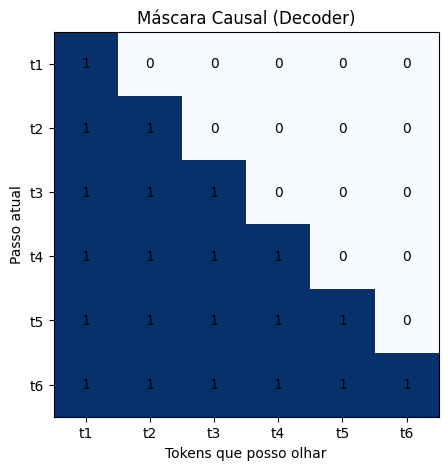

In [2]:
import torch
import matplotlib.pyplot as plt

# número de tokens
n_tokens = 6

# máscara causal: triangular inferior
mask = torch.tril(torch.ones((n_tokens, n_tokens)))

plt.figure(figsize=(5,5))
plt.imshow(mask, cmap="Blues")

# ticks e labels
plt.xticks(range(n_tokens), [f"t{j}" for j in range(1, n_tokens+1)])
plt.yticks(range(n_tokens), [f"t{j}" for j in range(1, n_tokens+1)])

# adiciona valores (0 ou 1) nas células
for i in range(n_tokens):
    for j in range(n_tokens):
        plt.text(j, i, int(mask[i,j].item()), ha="center", va="center", color="black")

plt.title("Máscara Causal (Decoder)")
plt.xlabel("Tokens que posso olhar")
plt.ylabel("Passo atual")
plt.show()

### Limitações de RNN/LSTM
- **Dependências longas**: a informação se perde ao longo da sequência.  
- **Pouca paralelização**: cada token depende do anterior, dificultando aceleração em hardware moderno.

### Onde isso aparece na prática?
- Tradução automática  
- Sumarização de textos  
- Geração de legendas para imagens  
- Correção gramatical  
- Data-to-text (gerar relatórios a partir de tabelas)

### Exemplo prático: Encoder–Decoder com LSTM + Atenção

Este código implementa, em **PyTorch**, um modelo **seq2seq** simples que reverte uma sequência de números.  
Por exemplo: entrada `[1, 2, 3, 4]` → saída esperada `[4, 3, 2, 1, <eos>]`.

---

#### 1. Vocabulário
- Usamos dígitos `0–9` como tokens básicos.  
- Adicionamos tokens especiais:  
  - `<pad>` (preenchimento)  
  - `<sos>` (início da sequência)  
  - `<eos>` (fim da sequência)  

Cada token recebe um índice numérico (`stoi` e `itos` fazem a conversão texto ↔ id).

---

#### 2. Encoder
- É um **LSTM bidirecional**: lê a sequência da esquerda para a direita **e** da direita para a esquerda.  
- Isso gera representações mais ricas, porque cada token “sabe” do que vem antes e do que vem depois.  
- A saída do encoder é uma matriz `H_enc` com dimensões `[S, 128]` (128 porque é 2×hidden size de 64).

---

#### 3. Atenção (Luong dot-product)
- O decoder gera um estado oculto `h_t` (dim 64).  
- Esse vetor é projetado para 128 dimensões (`Wq`) para ser compatível com `H_enc`.  
- Calculamos um **produto escalar** entre `h_t` e cada vetor de `H_enc` → isso gera um escore de relevância.  
- Após softmax, esses escores viram pesos de atenção.  
- O **contexto** é uma combinação ponderada das representações do encoder.

---

#### 4. Decoder
- Usa um **LSTM unidirecional**.  
- Em cada passo:
  1. Recebe o embedding do token anterior (`y_prev`).  
  2. Atualiza seu estado `(h, c)`.  
  3. Calcula a atenção sobre `H_enc` para gerar um **contexto**.  
  4. Concatena `[h ; contexto]` e passa por uma camada linear (`fc`) → distribui probabilidades sobre o vocabulário.  
  5. O token mais provável vira o próximo `y_prev`.  

- A geração continua até encontrar `<eos>` ou atingir o número máximo de passos.

---

#### 5. Teste rápido
- Criamos um exemplo aleatório (ex.: `[3, 1, 4]`).  
- O encoder processa a entrada → gera `H_enc`.  
- O decoder começa com `<sos>` e vai gerando tokens até `<eos>`.  
- No final, imprimimos:  
  - Entrada original  
  - Saída alvo (sequência invertida)  
  - Predição do modelo (sequência gerada)

---

Esse código não está treinado, então a predição inicial não será boa.  
Para funcionar bem, precisaríamos **treinar** com muitas sequências e ajustar os pesos.  

Mas como **demonstração didática**, ele já mostra:
- Como o encoder cria representações.  
- Como o decoder gera passo a passo (autoregressivo).  
- Como a atenção conecta encoder e decoder.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

# ----- Vocabulário e utilidades -----
PAD, SOS, EOS = "<pad>", "<sos>", "<eos>"
itos = [PAD, SOS, EOS] + [str(i) for i in range(10)]
stoi = {tok: i for i, tok in enumerate(itos)}
PAD_ID, SOS_ID, EOS_ID = stoi[PAD], stoi[SOS], stoi[EOS]
VOCAB_SIZE = len(itos)
device = "cuda" if torch.cuda.is_available() else "cpu"

def make_example(min_len=3, max_len=6):
    L = random.randint(min_len, max_len)
    seq = [random.randint(0,9) for _ in range(L)]
    src = [stoi[str(x)] for x in seq]
    tgt = [stoi[str(x)] for x in reversed(seq)] + [EOS_ID]
    return torch.tensor(src), torch.tensor(tgt)

# ----- Encoder LSTM bidirecional -----
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=32, hidden_enc=64):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD_ID)
        self.lstm = nn.LSTM(emb_dim, hidden_enc, batch_first=True, bidirectional=True)
        self.enc_dim = hidden_enc * 2  # por ser bidirecional

    def forward(self, src_ids):
        # src_ids: [S] (sequência de um exemplo)
        x = self.emb(src_ids.unsqueeze(0))     # [1, S, E]
        H_enc, _ = self.lstm(x)                # [1, S, enc_dim]
        return H_enc

# ----- Atenção com projeção do query (Luong dot com Wq) -----
class LuongDotAttention(nn.Module):
    def __init__(self, dec_hidden, enc_dim):
        super().__init__()
        # projeta query (dim dec_hidden) para a dimensão do encoder (enc_dim)
        self.Wq = nn.Linear(dec_hidden, enc_dim, bias=False)

    def forward(self, query, keys, values):
        """
        query: [1, dec_hidden]
        keys:  [1, S, enc_dim]
        values:[1, S, enc_dim]
        """
        q = self.Wq(query).unsqueeze(1)          # [1, 1, enc_dim]
        attn_scores = torch.bmm(q, keys.transpose(1, 2))  # [1, 1, S]
        attn_weights = F.softmax(attn_scores, dim=-1)     # [1, 1, S]
        context = torch.bmm(attn_weights, values).squeeze(1)  # [1, enc_dim]
        return context, attn_weights.squeeze(0).squeeze(0)    # [1, enc_dim], [S]

# ----- Decoder LSTM + atenção (concatena h_t com context) -----
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=32, dec_hidden=64, enc_dim=128):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=PAD_ID)
        self.lstm = nn.LSTMCell(emb_dim, dec_hidden)
        self.attn = LuongDotAttention(dec_hidden=dec_hidden, enc_dim=enc_dim)
        self.fc = nn.Linear(dec_hidden + enc_dim, vocab_size)  # concat [h_t ; context]
        self.dec_hidden = dec_hidden
        self.enc_dim = enc_dim

    def forward(self, tgt_ids, H_enc, max_steps=None):
        """
        Geração greedy até EOS ou max_steps.
        tgt_ids: tensor alvo (usado apenas para limitar passos, opcional)
        H_enc: [1, S, enc_dim]
        """
        S = H_enc.size(1)
        steps = max_steps if max_steps is not None else (tgt_ids.size(0) if tgt_ids is not None else S + 1)

        # estados iniciais do decoder
        h = torch.zeros(1, self.dec_hidden, device=H_enc.device)
        c = torch.zeros(1, self.dec_hidden, device=H_enc.device)

        outputs = []
        y_prev = torch.tensor([SOS_ID], device=H_enc.device)

        for _ in range(steps):
            emb = self.emb(y_prev)               # [1, emb_dim]
            h, c = self.lstm(emb, (h, c))        # [1, dec_hidden]
            context, _ = self.attn(h, H_enc, H_enc)  # context: [1, enc_dim]
            logits = self.fc(torch.cat([h, context], dim=-1))  # [1, V]
            y_prev = logits.argmax(dim=-1)       # [1]
            outputs.append(y_prev.item())
            if y_prev.item() == EOS_ID:
                break
        return outputs

# ----- Montagem e teste rápido -----
encoder = Encoder(VOCAB_SIZE, emb_dim=32, hidden_enc=64).to(device)
enc_dim = encoder.enc_dim  # 128
decoder = Decoder(VOCAB_SIZE, emb_dim=32, dec_hidden=64, enc_dim=enc_dim).to(device)

src, tgt = make_example()
src, tgt = src.to(device), tgt.to(device)

H_enc = encoder(src)          # [1, S, 128]
pred_ids = decoder(tgt, H_enc)

print("input :", [itos[i] for i in src.tolist()])
print("target:", [itos[i] for i in tgt.tolist()])
print("pred  :", [itos[i] for i in pred_ids])

input : ['5', '3', '3', '4', '6', '9']
target: ['9', '6', '4', '3', '3', '5', '<eos>']
pred  : ['0', '8', '8', '5', '0', '8', '8']
